# Introduction:
We revisit the Keystroke dynamics dataset... and use neural networks to predict user class.  Recall that Keystroke dynamics is the analysis of typing rhythms to discriminate between different users — has been proposed for detecting imposters (i.e., both insiders and external attackers).  Our objective is to create detectors that can discriminate users from one another based on their keystroke dynamics and assess their performance.

The attached dataset contains keystroke dynamics information. Keystroke dynamics are the natural patterns that individuals exhibit when typing on a keyboard. The dataset contains samples from several individuals typing in the same password and a variety of features are measured and tabulated. The feature names are somewhat ambiguous, but they mostly represent timing information. Column names of the form `DD.key1.key2` designate the time elapsed between pressing key 1 and pressing key 2 and names of the form `UD.key1.key2` designate the time elapsed between releasing key 1 and pressing key 2. More information can be found regarding the dataset and associated research here: https://www.cs.cmu.edu/~keystroke/#sec2.

## Preps

In [105]:
# Load libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


# Read in dataset
frame = pd.read_csv('DSL-StrongPasswordData.csv')

# Quick analysis function 
def quick_analysis(df):
    st = '\033[1m' + 'Data types of the dataset: ' + '\033[0m' + '\n'
    st = st + str(df.dtypes)
    st = st + '\n'
    st = st + '\033[1m' + 'Number of Rows: ' + '\033[0m' + str(df.shape[0]) + '\n'
    st = st + '\033[1m' + 'Number of Columns: ' + '\033[0m' + str(df.shape[1]) + '\n'
    st = st + '\033[1m' + 'Index Range: ' + '\033[0m' + str(len(df.index)) + '\n'
    st = st + '\033[1m' + 'Column names: ' + '\033[0m' + '\n'
    
    for name in df.columns:
        st = st + str(name +', ' + '\n')
    
    #number of null values
    nv = df.isnull().sum().sum()
    st = st + '\n'
    st = st + '\033[1m' + 'Number of null values: ' + '\033[0m' + str(nv) + '\n'
    st = st + '\033[1m' + 'Mean values: ' + '\033[0m' + str(np.mean(df)) + '\n'
    st = st + '\033[1m' + 'Standard deviations: ' + '\033[0m' + str(np.std(df)) + '\n'
    st = st + '\033[1m' + 'Absolute Average Deviation (AAD): ' + '\033[0m' + str(df.mad()) + '\n'

    return st

print(quick_analysis(frame.drop(['subject'], axis='columns')))

Data types of the dataset: 
sessionIndex         int64
rep                  int64
H.period           float64
DD.period.t        float64
UD.period.t        float64
H.t                float64
DD.t.i             float64
UD.t.i             float64
H.i                float64
DD.i.e             float64
UD.i.e             float64
H.e                float64
DD.e.five          float64
UD.e.five          float64
H.five             float64
DD.five.Shift.r    float64
UD.five.Shift.r    float64
H.Shift.r          float64
DD.Shift.r.o       float64
UD.Shift.r.o       float64
H.o                float64
DD.o.a             float64
UD.o.a             float64
H.a                float64
DD.a.n             float64
UD.a.n             float64
H.n                float64
DD.n.l             float64
UD.n.l             float64
H.l                float64
DD.l.Return        float64
UD.l.Return        float64
H.Return           float64
dtype: object
Number of Rows: 20400
Number of Columns: 33
Index Range: 20400
Colu

In [2]:
# better view of attributes
frame.T

,0,1,2,3,4,5,6,7,8,9,...,20390,20391,20392,20393,20394,20395,20396,20397,20398,20399
subject,s002,s002,s002,s002,s002,s002,s002,s002,s002,s002,...,s057,s057,s057,s057,s057,s057,s057,s057,s057,s057
sessionIndex,1,1,1,1,1,1,1,1,1,1,...,8,8,8,8,8,8,8,8,8,8
rep,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
H.period,0.1491,0.1111,0.1328,0.1291,0.1249,0.1394,0.1064,0.0929,0.0966,0.1093,...,0.0649,0.0831,0.0665,0.0834,0.0918,0.0884,0.0655,0.0939,0.0923,0.0596
DD.period.t,0.3979,0.3451,0.2072,0.2515,0.2317,0.2343,0.2069,0.181,0.1797,0.1807,...,0.0754,0.0865,0.0678,0.1147,0.1018,0.0685,0.063,0.1189,0.1294,0.131
UD.period.t,0.2488,0.234,0.0744,0.1224,0.1068,0.0949,0.1005,0.0881,0.0831,0.0714,...,0.0105,0.0034,0.0013,0.0313,0.01,-0.0199,-0.0025,0.025,0.0371,0.0714
H.t,0.1069,0.0694,0.0731,0.1059,0.0895,0.0813,0.0866,0.0818,0.0771,0.0731,...,0.0944,0.0757,0.0902,0.1002,0.0802,0.1095,0.091,0.1008,0.0913,0.0992
DD.t.i,0.1674,0.1283,0.1291,0.2495,0.1676,0.1299,0.1368,0.1378,0.1296,0.1457,...,0.1451,0.1274,0.1601,0.1055,0.1158,0.129,0.1148,0.1122,0.099,0.1103
UD.t.i,0.0605,0.0589,0.056,0.1436,0.0781,0.0486,0.0502,0.056,0.0525,0.0726,...,0.0507,0.0517,0.0699,0.0053,0.0356,0.0195,0.0238,0.0114,0.0077,0.0111
H.i,0.1169,0.0908,0.0821,0.104,0.0903,0.0744,0.08,0.0747,0.0839,0.0766,...,0.0599,0.0608,0.0515,0.0744,0.0821,0.0945,0.0916,0.0721,0.0992,0.0998


## Question 4. 
Examine the DSL-StrongPasswordData dataset. How many unique subjects are
there?

In [3]:
# Answer here

# find the number of unique values in the subject column
unique_subjects = pd.unique(frame.subject).shape[0]

# Print results
print('There are {} unique subjects in the dataset.'.format(unique_subjects))

There are 51 unique subjects in the dataset.


## Question 5.  
Create label data for training and validation. Use the data under the `['subject']` column in the dataset as labels and one-hot encode them. What is the shape of the resulting label array?

In [4]:
# Answer here

#One hot encode subject data, store in label vector
lb = preprocessing.LabelBinarizer()

labels = lb.fit_transform(frame.subject)
labels.shape

(20400, 51)

## Question 6.
Create a feature data array for training by dropping the `['subject','sessionIndex','rep']` columns from the original dataframe. Some features may be highly correlated. Run a correlation on the newly created features array and drop features with greater than 0.95 correlation. How many features are left?

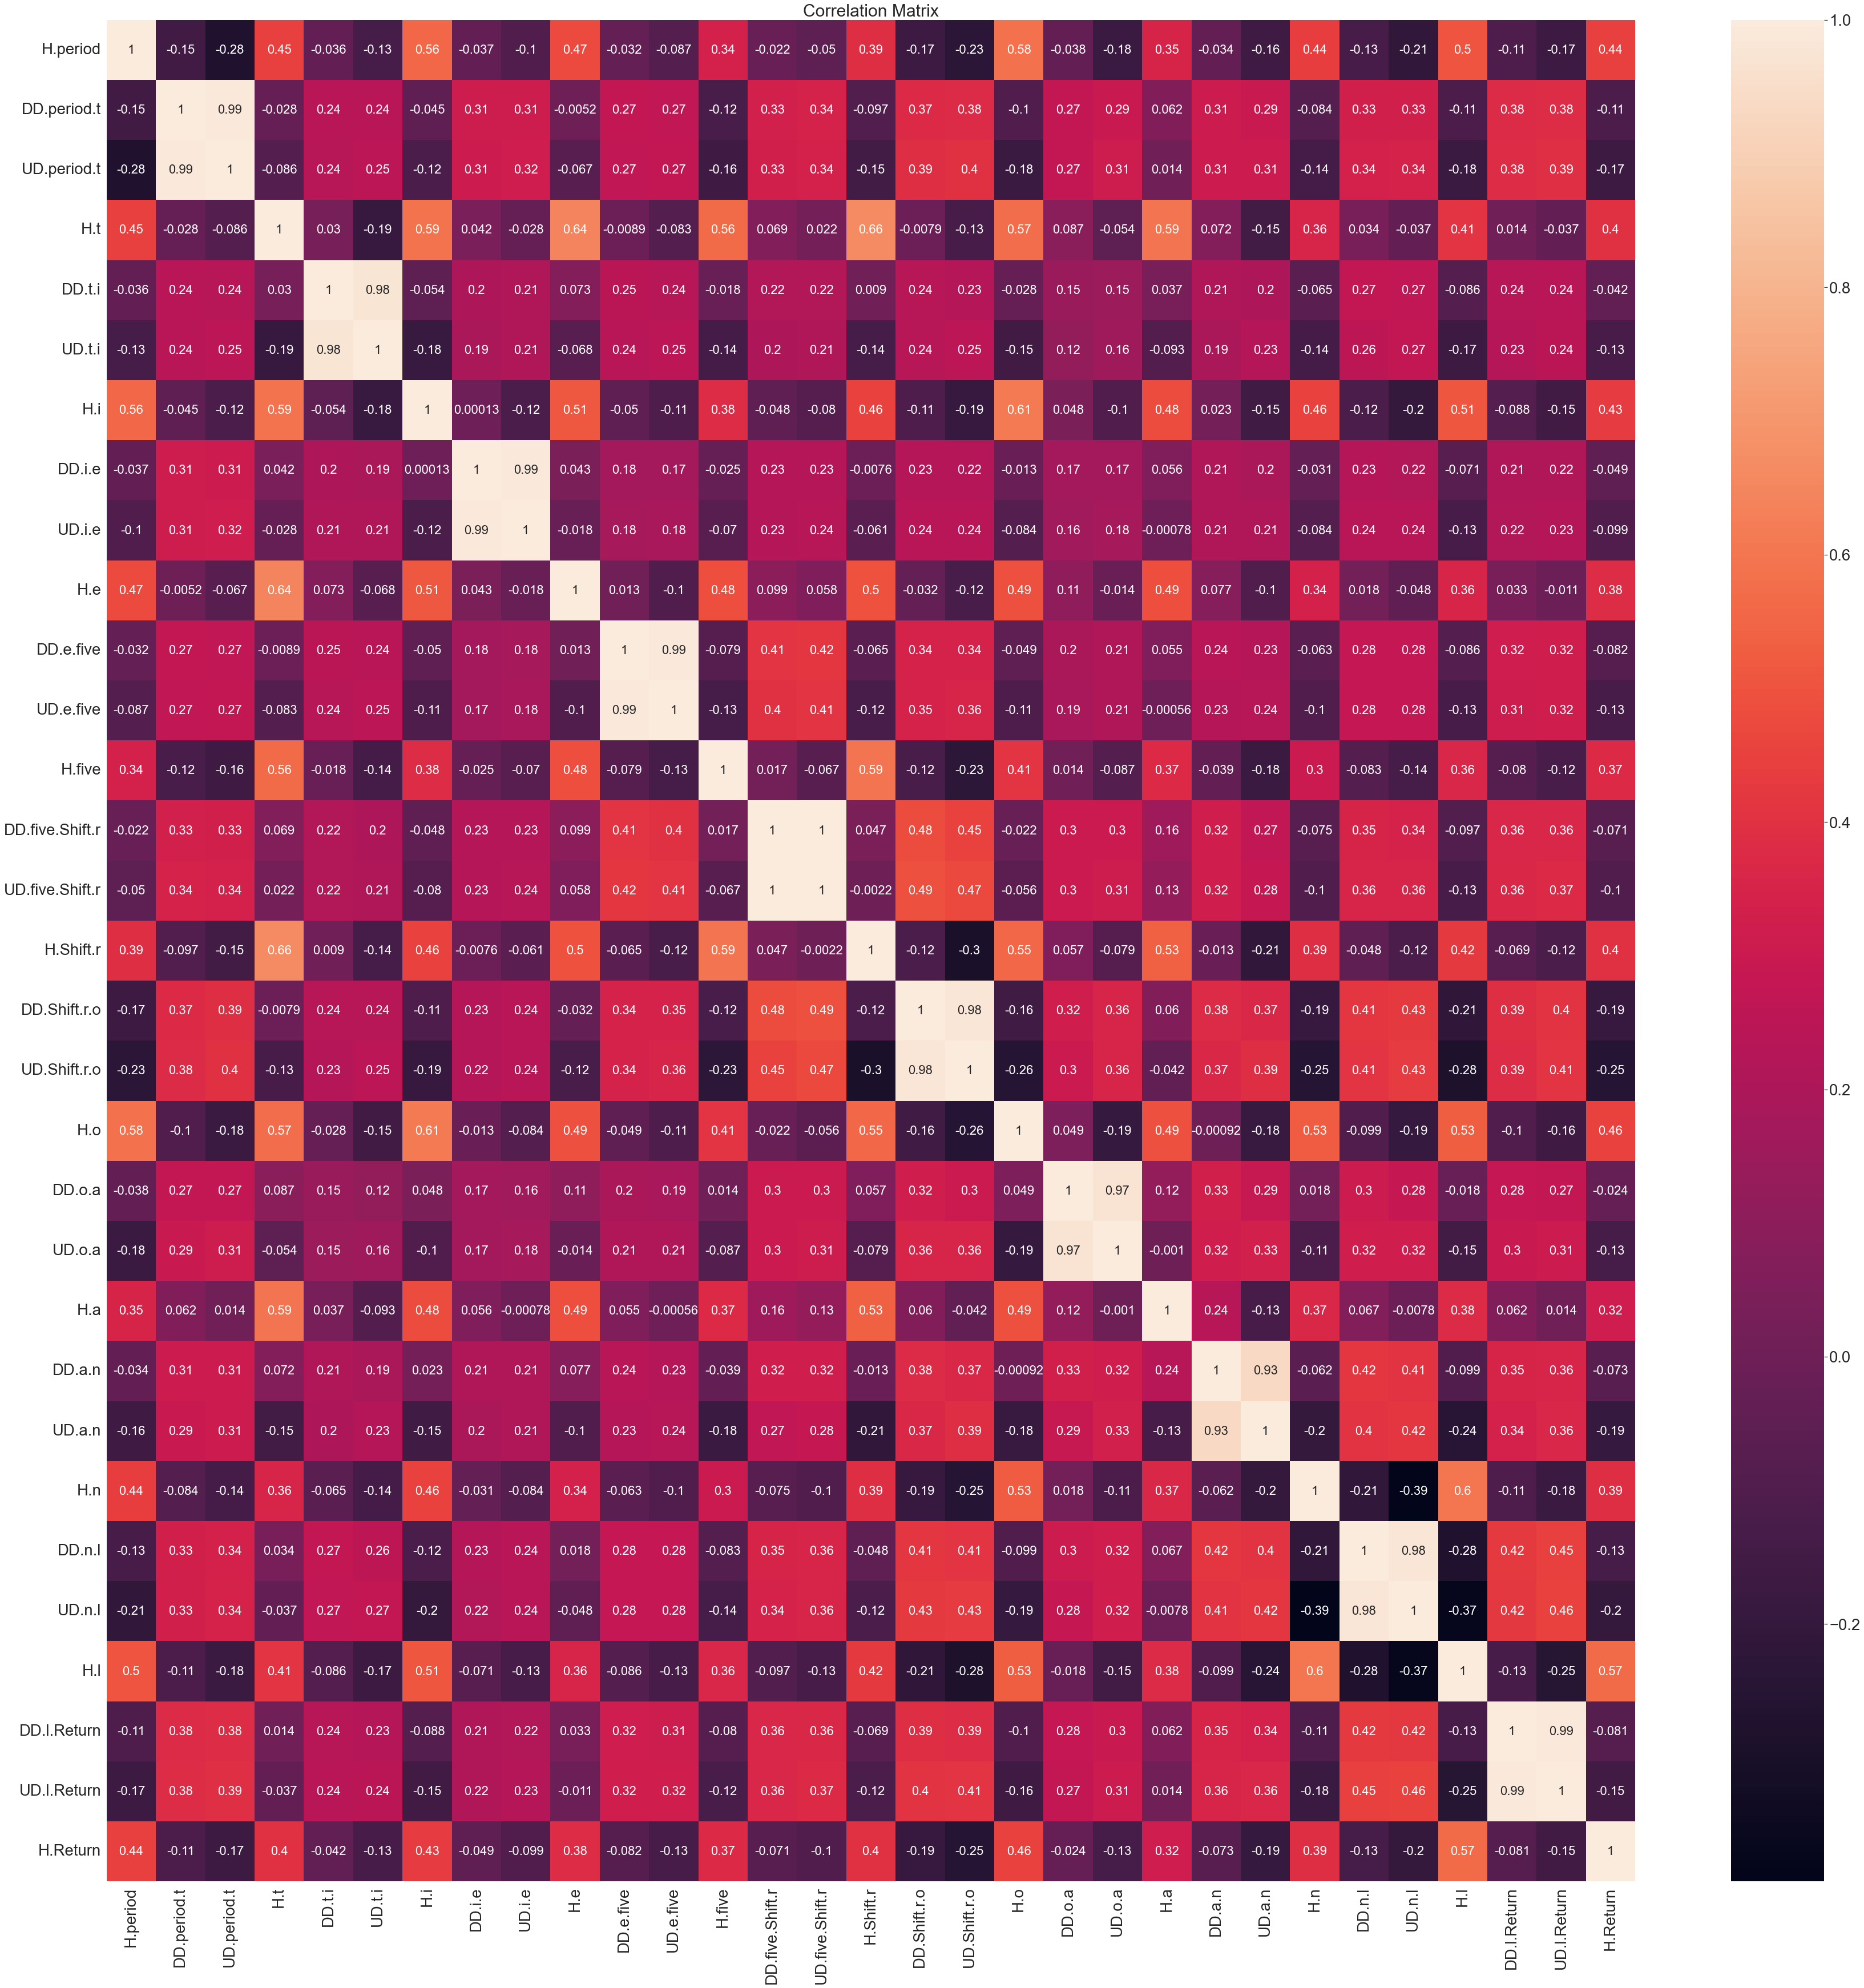

In [5]:
# Answer here

# drop the features
frame2 = frame.drop(['subject','sessionIndex','rep'], axis = 1)

# compute correlation matrix
corr_matrix = frame2.corr()

# plot corr matrix
fig = plt.figure(figsize=(60, 60))
sns.set(font_scale=2.5)
ax = sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 22},)
ax.set_title('Correlation Matrix')
plt.show()

In [37]:
# pick up features with coor greater than 0.95
(corr_matrix>0.95).sum()-1

H.period           0
DD.period.t        1
UD.period.t        1
H.t                0
DD.t.i             1
UD.t.i             1
H.i                0
DD.i.e             1
UD.i.e             1
H.e                0
DD.e.five          1
UD.e.five          1
H.five             0
DD.five.Shift.r    1
UD.five.Shift.r    1
H.Shift.r          0
DD.Shift.r.o       1
UD.Shift.r.o       1
H.o                0
DD.o.a             1
UD.o.a             1
H.a                0
DD.a.n             0
UD.a.n             0
H.n                0
DD.n.l             1
UD.n.l             1
H.l                0
DD.l.Return        1
UD.l.Return        1
H.Return           0
dtype: int64

In [6]:
# drop the second features with high correlation to a previous feature
frame3 = frame2.drop(['UD.period.t',
                      'UD.t.i',
                      'UD.i.e',
                      'UD.e.five',
                      'UD.five.Shift.r',
                      'UD.Shift.r.o',
                      'UD.o.a',
                      'UD.n.l',
                      'UD.l.Return'], axis = 1)
frame3.T

,0,1,2,3,4,5,6,7,8,9,...,20390,20391,20392,20393,20394,20395,20396,20397,20398,20399
H.period,0.1491,0.1111,0.1328,0.1291,0.1249,0.1394,0.1064,0.0929,0.0966,0.1093,...,0.0649,0.0831,0.0665,0.0834,0.0918,0.0884,0.0655,0.0939,0.0923,0.0596
DD.period.t,0.3979,0.3451,0.2072,0.2515,0.2317,0.2343,0.2069,0.1810,0.1797,0.1807,...,0.0754,0.0865,0.0678,0.1147,0.1018,0.0685,0.0630,0.1189,0.1294,0.1310
H.t,0.1069,0.0694,0.0731,0.1059,0.0895,0.0813,0.0866,0.0818,0.0771,0.0731,...,0.0944,0.0757,0.0902,0.1002,0.0802,0.1095,0.0910,0.1008,0.0913,0.0992
DD.t.i,0.1674,0.1283,0.1291,0.2495,0.1676,0.1299,0.1368,0.1378,0.1296,0.1457,...,0.1451,0.1274,0.1601,0.1055,0.1158,0.1290,0.1148,0.1122,0.0990,0.1103
H.i,0.1169,0.0908,0.0821,0.1040,0.0903,0.0744,0.0800,0.0747,0.0839,0.0766,...,0.0599,0.0608,0.0515,0.0744,0.0821,0.0945,0.0916,0.0721,0.0992,0.0998
DD.i.e,0.2212,0.1357,0.1542,0.2038,0.1589,0.1412,0.1407,0.1367,0.1425,0.1241,...,0.0620,0.0486,0.0391,0.0860,0.0697,0.0757,0.0636,0.0462,0.0897,0.0813
H.e,0.1417,0.0829,0.0808,0.0900,0.0805,0.0863,0.0789,0.0776,0.0755,0.0813,...,0.0625,0.0998,0.0794,0.1369,0.0934,0.1328,0.1256,0.0903,0.1016,0.1493
DD.e.five,1.1885,1.1970,1.0408,1.0556,0.8629,0.9373,0.7967,0.6447,0.7357,0.7550,...,0.1756,0.0467,0.1923,0.0970,0.6800,0.0826,0.0852,0.2045,0.0570,0.1237
H.five,0.1146,0.0689,0.0892,0.0913,0.0742,0.0942,0.0855,0.1373,0.0800,0.0826,...,0.0744,0.1085,0.0736,0.1340,0.0599,0.1000,0.0987,0.0733,0.0820,0.1137
DD.five.Shift.r,1.6055,0.7822,0.6203,1.2564,0.8955,1.0896,1.2005,1.1876,0.9406,0.8065,...,0.2154,0.2465,0.2604,0.3599,0.6376,0.2398,0.2441,0.2190,0.2881,0.2831


## Question 7.
Use a standard scaler to remove the mean from each feature and give each unit standard deviation. Then use the train_test splitter with a `test_size` of 0.3 to create training and validation data. How many observations are in your validation
data?

In [7]:
# Answer here
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# convert data to numpy arrays
features = frame3.iloc[:,0:22].to_numpy()

# standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Split data into training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features_standardized, labels, test_size=0.3, random_state=0)  

# Print results
print('There are {} observations in the validation data.'.format(features_test.shape[0]))

There are 6120 observations in the validation data.


## Question 8.
Build a Multiclass Classifier using the Keras Sequential module. The architecture should have two hidden Dense layers with 100 nodes and one output Dense layer with the approriate number of output nodes. Fit the model with the following parameters: Epochs = 50, Batch size = 50, and Optimizer = 'Adam'. What is the approximate validation accuracy?

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               2300      
                                                                 
 dense_19 (Dense)            (None, 100)               10100     
                                                                 
 dense_20 (Dense)            (None, 51)                5151      
                                                                 
Total params: 17,551
Trainable params: 17,551
Non-trainable params: 0
_________________________________________________________________


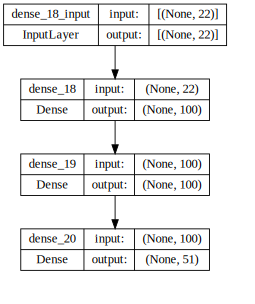

In [108]:
# Answer here

# Load libraries
from keras import models
from keras import layers

# Start neural network
network = models.Sequential()

# Add fully connected layer with a ReLU activation function
number_of_input_nodes = features_standardized.shape[1]
network.add(layers.Dense(units=100, activation="relu", input_shape=(number_of_input_nodes,)))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=100, activation="relu"))

# Add fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=51, activation="sigmoid"))

# Compile neural network
network.compile(loss="binary_crossentropy", # Cross-entropy
                optimizer="Adam", #
                metrics=["accuracy"]) # Accuracy performance metric

network.summary()

# Visualize network architecture
SVG(model_to_dot(network, show_shapes=True, show_layer_names=True, dpi = 65).create(prog="dot", format="svg"))

In [109]:
# Train neural network
history = network.fit(features_train, # Features
                      target_train, # Target vector
                      epochs=50, # Number of epochs
                      verbose=1, # Print description after each epoch
                      batch_size=50, # Number of observations per batch
                      validation_data=(features_test, target_test)) # Test data

Epoch 1/50
286/286 [==============================] - 7s 16ms/step - loss: 0.1329 - accuracy: 0.2227 - val_loss: 0.0618 - val_accuracy: 0.5211
Epoch 2/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0475 - accuracy: 0.6410 - val_loss: 0.0373 - val_accuracy: 0.7180
Epoch 3/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0332 - accuracy: 0.7558 - val_loss: 0.0298 - val_accuracy: 0.7786
Epoch 4/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0280 - accuracy: 0.7954 - val_loss: 0.0261 - val_accuracy: 0.8093
Epoch 5/50
286/286 [==============================] - 3s 10ms/step - loss: 0.0252 - accuracy: 0.8140 - val_loss: 0.0241 - val_accuracy: 0.8250
Epoch 6/50
286/286 [==============================] - 3s 11ms/step - loss: 0.0230 - accuracy: 0.8353 - val_loss: 0.0227 - val_accuracy: 0.8356
Epoch 7/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0214 - accuracy: 0.8448 - val_loss: 0.0215 - val_accuracy: 0.8492

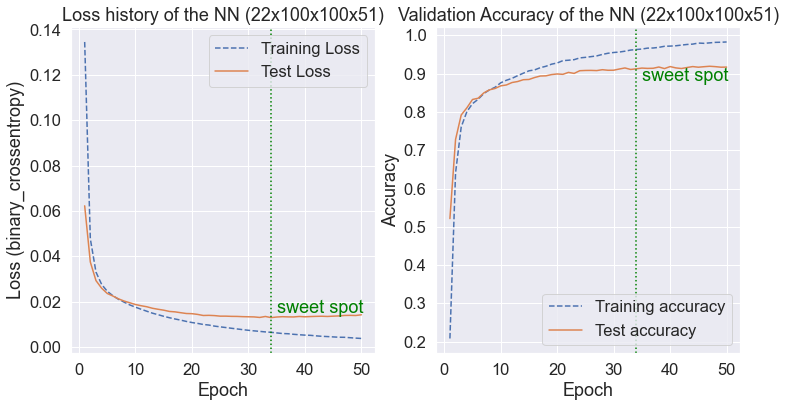

In [68]:
# Plot the training and test loss and accuracy history to assess performance

# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig, axs = plt.subplots(1,2,figsize=(12, 6), gridspec_kw=dict(width_ratios=[6, 6]))
sns.set(font_scale=1.5)

#fist plot: loss
ax = sns.lineplot(x=epoch_count, y=training_loss, linestyle ='--', ax=axs[0])
ax = sns.lineplot(x=epoch_count, y=test_loss, ax=axs[0])
ax.set_title('Loss history of the NN (22x100x100x51)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (binary_crossentropy)')
ax.legend(["Training Loss", "Test Loss"])
ax.axvline(x=34, linestyle ='dotted', color='green')
ax.text(35, 0.015, 'sweet spot', color ='green')

#second plot: accuracy
ax = sns.lineplot(x=epoch_count, y=training_accuracy, linestyle ='--', ax = axs[1])
ax = sns.lineplot(x=epoch_count, y=test_accuracy, ax = axs[1])
ax.set_title('Validation Accuracy of the NN (22x100x100x51)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.axvline(x=34, linestyle ='dotted', color='green')
ax.text(35, 0.88, 'sweet spot', color ='green')
ax.legend(["Training accuracy", "Test accuracy"])

plt.show()

In [69]:
print('The max validation accuracy of the NN with the test set is {}'.format(np.max(history.history['val_accuracy'])))

The max validation accuracy of the NN with the test set is 0.9194444417953491


## Question 9.
Between the two hidden layers of the the Multiclass Classifier, add a dropout layer with a dropout rate of 0.3. What happens to the model performance?

In [70]:
# Answer here
# Start neural network
network2 = models.Sequential()

# Add fully connected layer with a ReLU activation function
number_of_input_nodes = features_standardized.shape[1]
network2.add(layers.Dense(units=100, activation="relu", input_shape=(number_of_input_nodes,)))

# Add a dropout layer for input layer
network2.add(layers.Dropout(0.3))

# Add fully connected layer with a ReLU activation function
network2.add(layers.Dense(units=100, activation="relu"))

# Add fully connected layer with a sigmoid activation function
network2.add(layers.Dense(units=51, activation="sigmoid"))

# Compile neural network
network2.compile(loss="binary_crossentropy", # Cross-entropy
                optimizer="Adam", #
                metrics=["accuracy"]) # Accuracy performance metric

network2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               2300      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 51)                5151      
                                                                 
Total params: 17,551
Trainable params: 17,551
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Train neural network
history2 = network2.fit(features_train, # Features
                      target_train, # Target vector
                      epochs=50, # Number of epochs
                      verbose=1, # Print description after each epoch
                      batch_size=50, # Number of observations per batch
                      validation_data=(features_test, target_test)) # Test data

Epoch 1/50
286/286 [==============================] - 8s 19ms/step - loss: 0.1337 - accuracy: 0.1768 - val_loss: 0.0625 - val_accuracy: 0.5064
Epoch 2/50
286/286 [==============================] - 4s 12ms/step - loss: 0.0539 - accuracy: 0.5494 - val_loss: 0.0394 - val_accuracy: 0.7263
Epoch 3/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0410 - accuracy: 0.6663 - val_loss: 0.0321 - val_accuracy: 0.7539
Epoch 4/50
286/286 [==============================] - 4s 13ms/step - loss: 0.0364 - accuracy: 0.7022 - val_loss: 0.0282 - val_accuracy: 0.7964
Epoch 5/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0336 - accuracy: 0.7233 - val_loss: 0.0264 - val_accuracy: 0.8054
Epoch 6/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0312 - accuracy: 0.7487 - val_loss: 0.0244 - val_accuracy: 0.8178
Epoch 7/50
286/286 [==============================] - 3s 12ms/step - loss: 0.0295 - accuracy: 0.7626 - val_loss: 0.0237 - val_accuracy: 0.8281

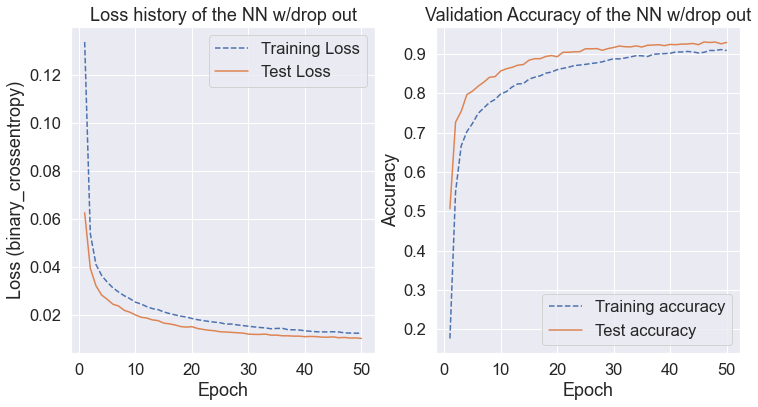

In [74]:
# Plot the training and test loss and accuracy history to assess performance

# Get training and test accuracy histories
training_accuracy2 = history2.history["accuracy"]
test_accuracy2 = history2.history["val_accuracy"]

# Get training and test loss histories
training_loss2 = history2.history["loss"]
test_loss2 = history2.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig, axs = plt.subplots(1,2,figsize=(12, 6), gridspec_kw=dict(width_ratios=[6, 6]))
sns.set(font_scale=1.5)

#first plot: loss
ax = sns.lineplot(x=epoch_count, y=training_loss2, linestyle ='--', ax = axs[0])
ax = sns.lineplot(x=epoch_count, y=test_loss2, ax = axs[0])
ax.set_title('Loss history of the NN w/drop out')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (binary_crossentropy)')
ax.legend(["Training Loss", "Test Loss"])

# second plot: accuracy
ax = sns.lineplot(x=epoch_count, y=training_accuracy2, linestyle ='--',ax = axs[1])
ax = sns.lineplot(x=epoch_count, y=test_accuracy2, ax = axs[1])
ax.set_title('Validation Accuracy of the NN w/drop out')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(["Training accuracy", "Test accuracy"])



plt.show()

In [85]:
print('The max validation accuracy of the NN w/drop out layer with the test set is {}'.format(np.max(history2.history['val_accuracy'])))
print('The max training accuracy of the NN w/drop out layer with the test set is {}'.format(np.max(history2.history['accuracy'])))

The max validation accuracy of the NN w/drop out layer with the test set is 0.9302287697792053
The max training accuracy of the NN w/drop out layer with the test set is 0.9109944105148315


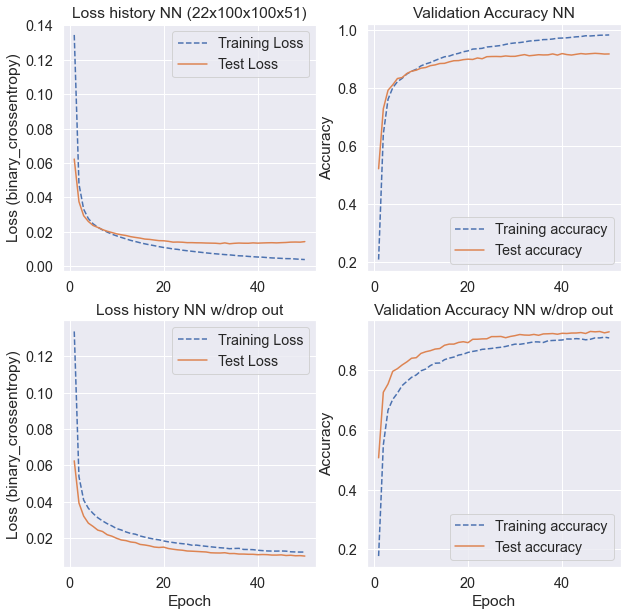

In [82]:
# all charts together for better analysis

fig, axs = plt.subplots(2,2,figsize=(10, 10), gridspec_kw=dict(width_ratios=[5, 5]))
sns.set(font_scale=1.3)

#fist plot: loss
ax = sns.lineplot(x=epoch_count, y=training_loss, linestyle ='--', ax=axs[0][0])
ax = sns.lineplot(x=epoch_count, y=test_loss, ax=axs[0][0])
ax.set_title('Loss history NN (22x100x100x51)')
ax.set_ylabel('Loss (binary_crossentropy)')
ax.legend(["Training Loss", "Test Loss"])

#second plot: accuracy
ax = sns.lineplot(x=epoch_count, y=training_accuracy, linestyle ='--', ax = axs[0][1])
ax = sns.lineplot(x=epoch_count, y=test_accuracy, ax = axs[0][1])
ax.set_title('Validation Accuracy NN')
ax.set_ylabel('Accuracy')
ax.legend(["Training accuracy", "Test accuracy"])

#third plot: loss
ax = sns.lineplot(x=epoch_count, y=training_loss2, linestyle ='--', ax = axs[1][0])
ax = sns.lineplot(x=epoch_count, y=test_loss2, ax = axs[1][0])
ax.set_title('Loss history NN w/drop out')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (binary_crossentropy)')
ax.legend(["Training Loss", "Test Loss"])

# fourth plot: accuracy
ax = sns.lineplot(x=epoch_count, y=training_accuracy2, linestyle ='--',ax = axs[1][1])
ax = sns.lineplot(x=epoch_count, y=test_accuracy2, ax = axs[1][1])
ax.set_title('Validation Accuracy NN w/drop out')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(["Training accuracy", "Test accuracy"])

plt.show()

## Question 10.
Using the data from the 'predictions.csv' file and the Multiclass Classifier with dropout, predict which users these feature sets come from. Remember Python uses zero indexing.

In [88]:
# Answer here

# Read in dataset
predictions = pd.read_csv('predictions.csv')

predictions.head(5)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.309832,-0.739806,-0.777692,-0.526821,-0.021032,-0.213605,-0.624734,-0.683413,-0.924503,-0.904931,...,-0.017179,-0.471408,-1.302163,-0.514525,-0.044782,-0.133366,0.174247,-0.874451,-0.120450,0.677337
1,0.196499,-0.822789,1.319042,-0.144766,0.146340,-0.562622,-0.445197,-0.772357,-1.715475,-0.061408,...,0.849382,-0.110091,0.075739,-0.452153,-0.489673,0.218001,0.021105,0.229693,-0.227822,-0.441006
2,3.369509,-0.199739,0.513167,0.153107,2.913553,0.897787,1.405661,0.498864,0.689630,0.096849,...,1.761353,0.353521,-0.622226,0.531840,0.772754,0.019544,0.089686,-0.345309,0.004671,0.032560
3,0.550931,-0.459116,-0.172374,-0.140719,1.124535,-0.459504,-0.869557,0.108038,3.159115,1.135121,...,0.569358,-0.647843,0.387376,-0.122604,-0.268178,-0.331822,-0.121383,0.797639,-0.934619,0.990619
4,-0.357090,-0.151673,-0.095797,-0.732418,-0.895085,-0.177910,0.002012,-0.436179,-0.708366,-0.251930,...,-0.179896,0.097314,-0.274532,-0.615996,-0.527698,-0.923939,0.054397,0.053312,0.313922,-0.054868


In [136]:
# standardize predictions
predictions_array = predictions.to_numpy()
predictions_std = scaler.fit_transform(predictions_array)

#predict subjects
predicted_target_std = network.predict(predictions_std)
predicted_target = network.predict(predictions)
np.round(predicted_target[0])


1/1 [==============================] - 1s 597ms/step


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [124]:
unique_subjects = np.unique(labels, axis=0)

In [133]:
unique_subjects[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1])

In [137]:
lb.inverse_transform(predicted_target)

array(['s010', 's032', 's030', 's056', 's038'], dtype='<U4')